<a href="https://www.kaggle.com/code/rezniknn/yp-integrated-project-4?scriptVersionId=182029127" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import PIL

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential

from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

2024-06-07 11:24:14.952207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 11:24:14.952308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 11:24:15.139413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Сборный проект 4
### Задача

Необходимо разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## 1. Исследовательский анализ данных

### Оценки исполнителей

In [2]:
df_crowd = pd.read_csv(
    '/kaggle/input/dsplus-sp4/to_upload/CrowdAnnotations.tsv',
    sep='\t',
    header=None,
    names=['file_name', 'desc_id', 'share_match', 'match', 'mismatch']
)
df_crowd.head()

file_name                      desc_id  share_match  match  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0      3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0      0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0      0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0      0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0      0   

   mismatch  
0         0  
1         3  
2         3  
3         3  
4         3

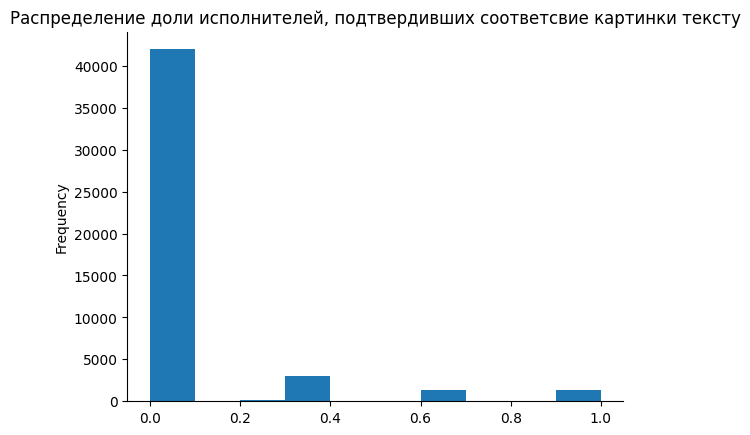

In [3]:
df_crowd['share_match'].plot(kind='hist', title='Распределение доли исполнителей, подтвердивших соответсвие картинки тексту')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
df_crowd['share_match'].value_counts()

share_match
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

In [5]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    47830 non-null  object 
 1   desc_id      47830 non-null  object 
 2   share_match  47830 non-null  float64
 3   match        47830 non-null  int64  
 4   mismatch     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Данные с оценками исполнителей содержат 47830 пар имя картинки - идентификатор описания. Из распределения доли оценок исполнителей, подтвердивших соответсвие картинки и текста, можно сделать вывод, что подавляющее большинство изображений не соответствует описанию и соответсвует не совсем точно и лишь небольшая доля изображений (<3%) полностью соответствует описанию, по мнению исполнителей

### Оценки экспертов

In [6]:
df_expert = pd.read_csv('/kaggle/input/dsplus-sp4/to_upload/ExpertAnnotations.tsv', sep='\t', header=None, names=['file_name', 'desc_id', 'score_1', 'score_2', 'score_3'])
df_expert.head()

file_name                      desc_id  score_1  score_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   score_3  
0        1  
1        2  
2        2  
3        2  
4        2

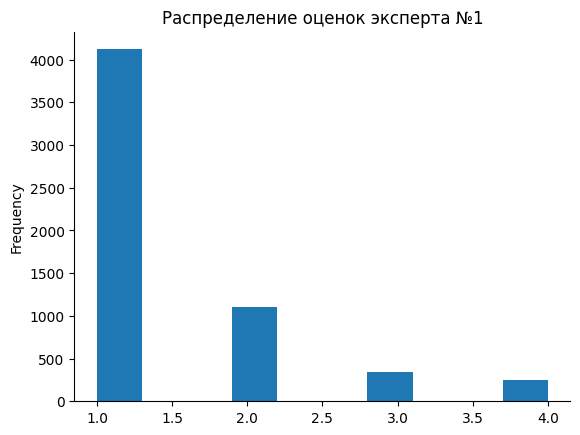

In [7]:
df_expert['score_1'].plot(kind='hist', title='Распределение оценок эксперта №1')
plt.gca().spines[['top', 'right',]].set_visible(False)

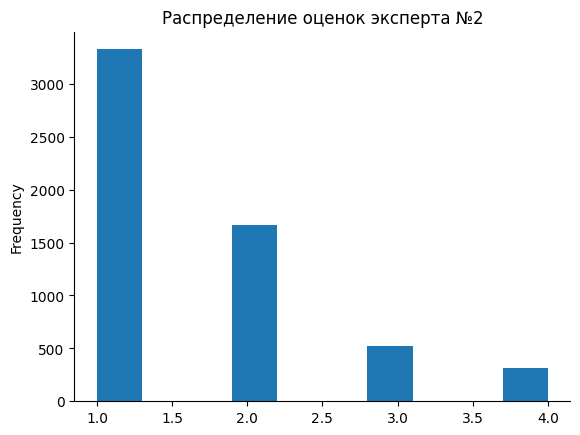

In [8]:
df_expert['score_2'].plot(kind='hist', title='Распределение оценок эксперта №2')
plt.gca().spines[['top', 'right',]].set_visible(False)

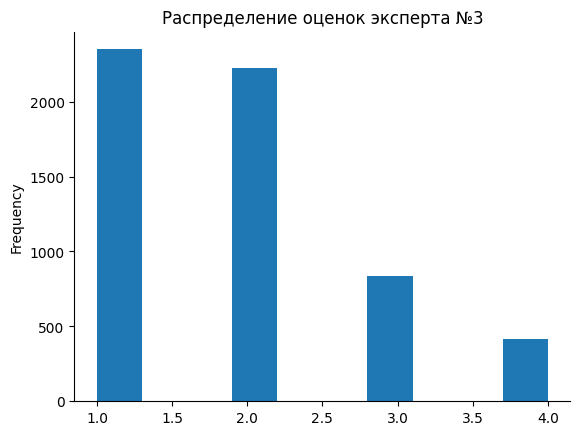

In [9]:
df_expert['score_3'].plot(kind='hist', title='Распределение оценок эксперта №3')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5822 non-null   object
 1   desc_id    5822 non-null   object
 2   score_1    5822 non-null   int64 
 3   score_2    5822 non-null   int64 
 4   score_3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


Данные с оценками экспертов содержат 5822 пар имя картинки - идентификатор описания, что намного меньше количества записей с оценками исполнителей. То есть как минимум для части изображений отсутствуют данные об оценках экспертов.

Из распределения оценок экспертов можно сделать выводы, что оценки 1 и 2, говорящие о низком соответсвии изображения картинке встречаются наиболее часто, в то время как оценки 3 и особенно 4 встречаются редко. Так же можно заключить, что эксперт №1 присваивает высокии оценки соответсвия реже, чем эксперты №2 и №3

### Суммарная оценка соответствия

In [11]:
df_crowd.shape

(47830, 5)

In [12]:
df_expert.shape

(5822, 5)

In [13]:
df_scores = pd.merge(df_crowd, df_expert, on=('file_name', 'desc_id'), how='left')
df_scores.head()

file_name                      desc_id  share_match  match  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0      3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0      0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0      0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0      0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0      0   

   mismatch  score_1  score_2  score_3  
0         0      NaN      NaN      NaN  
1         3      NaN      NaN      NaN  
2         3      NaN      NaN      NaN  
3         3      NaN      NaN      NaN  
4         3      NaN      NaN      NaN

In [14]:
df_scores.shape

(47830, 8)

In [15]:
df_scores = df_scores.fillna(0)
df_scores.head()

file_name                      desc_id  share_match  match  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0      3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0      0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0      0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0      0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0      0   

   mismatch  score_1  score_2  score_3  
0         0      0.0      0.0      0.0  
1         3      0.0      0.0      0.0  
2         3      0.0      0.0      0.0  
3         3      0.0      0.0      0.0  
4         3      0.0      0.0      0.0

In [16]:
df_scores['match_score'] = (
    (df_scores['share_match'] # доля исполнителей, подтвердивших соответсвие, в диапозоне от 0 до 1
    + (df_scores['score_1'] + df_scores['score_2'] + df_scores['score_3'])/12) # максимально возможная суммарная оценка экспертов - 12
    /2 # максимально возможная сумма двух составляющих - 2
)

In [17]:
df_scores = df_scores[['file_name', 'desc_id', 'match_score']]
df_scores.head()

file_name                      desc_id  match_score
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          0.5
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0

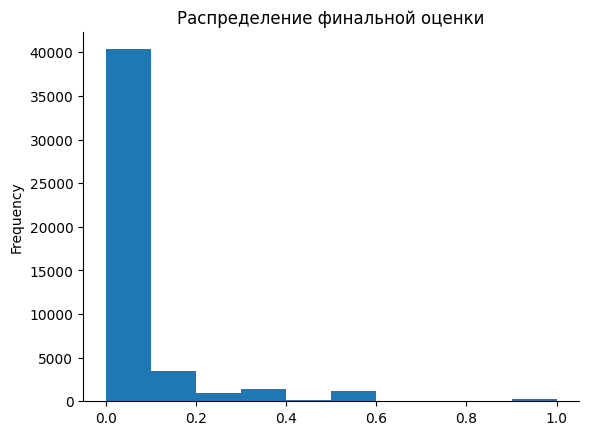

In [18]:
df_scores['match_score'].plot(kind='hist', title='Распределение финальной оценки')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
df_scores['match_score'].describe()

count    47830.000000
mean         0.047837
std          0.134896
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: match_score, dtype: float64

Оценки исполнителей и оценки экспертов были объединены в единый коэффициент соответсвия изображения описанию при помощи простого суммирования доли исполнителей, подтвердивших соответсвие изображения тексту (диапозон от 0 до 1) и суммы оценок трех экспертов (диапозон от 3 до 12). Так как оценки экспертов присутствуют не для всех изображений, пропущенные оценки были заменены на нулевые значения. Суммы были нормализованы, чтобы привести финальный коэффициент к диапозону от 0 до 1 для простоты дальнейшей работы.

### Обучающая выборка

In [20]:
df_train = pd.read_csv('/kaggle/input/dsplus-sp4/to_upload/train_dataset.csv')
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [22]:
len(df_train['image'].unique())

1000

In [23]:
len(df_train['query_id'].unique())

977

In [24]:
len(df_train['query_text'].unique())

977

In [25]:
df_train.duplicated().sum()

0

In [26]:
df_train_with_scores = pd.merge(
    df_train,
    df_scores,
    left_on=('image', 'query_id'),
    right_on=('file_name', 'desc_id')
    )[['image', 'query_id', 'query_text', 'match_score']]
df_train_with_scores.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  match_score  
0  A young child is wearing blue goggles and sitt...     0.125000  
1  A young child is wearing blue goggles and sitt...     0.208333  
2  A young child is wearing blue goggles and sitt...     1.000000  
3  A young child is wearing blue goggles and sitt...     0.291667  
4  A young child is wearing blue goggles and sitt...     0.125000

In [27]:
df_train_with_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        2329 non-null   object 
 1   query_id     2329 non-null   object 
 2   query_text   2329 non-null   object 
 3   match_score  2329 non-null   float64
dtypes: float64(1), object(3)
memory usage: 72.9+ KB


In [28]:
len(df_train_with_scores['image'].unique())

891

In [29]:
len(df_train_with_scores['query_id'].unique())

766

В обучающей выборке содержатся 5822 записей с информацией об 1000 уникальных изображений и 977 уникальных описаний изображений, то есть одному изображению может соответствовать несколько описаний, а так же к одному описанию может подходить несколько изображений. После объединения информации об изображениях и текстовых описаниях в обучающей выборке с финальным коэффициентом соответсвия, полученным на основе оценок исполнителей и экспертов, получился набор данных размером 2329 записей, содержащий 766 уникальных описаний для 891 уникальных изображений

### Тестовая выборка

In [30]:
df_test_images = pd.read_csv('/kaggle/input/dsplus-sp4/to_upload/test_images.csv')
df_test_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [31]:
df_test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [32]:
len(df_test_images['image'].unique())

100

In [33]:
df_test_queries = pd.read_csv('/kaggle/input/dsplus-sp4/to_upload/test_queries.csv', delimiter='|', index_col = 0)
df_test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [34]:
df_test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [35]:
len(df_test_queries['image'].unique())

100

In [36]:
len(df_test_queries['query_id'].unique())

500

In [37]:
len(df_test_queries['query_text'].unique())

500

In [38]:
df_test = pd.merge(df_test_images, df_test_queries, on='image')
df_test.head()

image                     query_id  \
0  3356748019_2251399314.jpg  3356748019_2251399314.jpg#0   
1  3356748019_2251399314.jpg  3356748019_2251399314.jpg#1   
2  3356748019_2251399314.jpg  3356748019_2251399314.jpg#2   
3  3356748019_2251399314.jpg  3356748019_2251399314.jpg#3   
4  3356748019_2251399314.jpg  3356748019_2251399314.jpg#4   

                                          query_text  
0  Cyclists are leaping into the air whilst being...  
1          Three dirt bike racers head over a jump .  
2  Three men form an arch during a BMX bike race ...  
3  Three men on mountain bikes go over a sand hill .  
4  Three riders wearing black jerseys jump their ...

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       500 non-null    object
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


Тестовая выборка содержит 100 изображений, а так же 500 пар соответствий изображения и текстового описания

**Выводы**:


*   Данные с оценками исполнителей содержат 47830 пар имя картинки - идентификатор описания. Из распределения доли оценок исполнителей, подтвердивших соответсвие картинки и текста, можно сделать вывод, что подавляющее большинство изображений не соответствует описанию и соответсвует не совсем точно и лишь небольшая доля изображений (<3%) полностью соответствует описанию, по мнению исполнителей

*   Данные с оценками экспертов содержат 5822 пар имя картинки - идентификатор описания, что намного меньше количества записей с оценками исполнителей. То есть как минимум для части изображений отсутствуют данные об оценках экспертов. Из распределения оценок экспертов можно сделать выводы, что оценки 1 и 2, говорящие о низком соответсвии изображения картинке встречаются наиболее часто, в то время как оценки 3 и особенно 4 встречаются редко. Так же можно заключить, что эксперт №1 присваивает высокии оценки соответсвия реже, чем эксперты №2 и №3

*   Оценки исполнителей и оценки экспертов были объединены в единый коэффициент соответсвия изображения описанию при помощи простого суммирования доли исполнителей, подтвердивших соответсвие изображения тексту (диапозон от 0 до 1) и суммы оценок трех экспертов (диапозон от 3 до 12). Так как оценки экспертов присутствуют не для всех изображений, пропущенные оценки были заменены на нулевые значения. Суммы были нормализованы, чтобы привести финальный коэффициент к диапозону от 0 до 1 для простоты дальнейшей работы

*   В обучающей выборке содержатся 5822 записей с информацией об 1000 уникальных изображений и 977 уникальных описаний изображений, то есть одному изображению может соответствовать несколько описаний, а так же к одному описанию может подходить несколько изображений. После объединения информации об изображениях и текстовых описаниях в обучающей выборке с финальным коэффициентом соответсвия, полученным на основе оценок исполнителей и экспертов, получился набор данных размером 2329 записей, содержащий 766 уникальных описаний для 891 уникальных изображений

*   Тестовая выборка содержит 100 изображений, а так же 500 пар соответствий изображения и текстового описания







## 2. Проверка данных

In [40]:
blacklist_keywords = ['child', 'kid', 'kids', 'girl', 'boy', 'toddler', 'infant', 'minor', 'teenager', 'baby', 'daughter', 'juvenile', 'offspring', 'son', 'youngster', 'youth']

In [41]:
len(blacklist_keywords)

16

In [42]:
len(df_train_with_scores['image'].unique())

891

In [43]:
len(df_train_with_scores[df_train_with_scores['query_text'].str.contains('|'.join(blacklist_keywords))]['image'].unique())

390

In [44]:
images_to_remove = df_train_with_scores[df_train_with_scores['query_text'].str.contains('|'.join(blacklist_keywords))]['image'].unique()

In [45]:
df_train_filtered = df_train_with_scores[~df_train_with_scores['image'].isin(images_to_remove)]

In [46]:
df_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1232 entries, 12 to 2328
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        1232 non-null   object 
 1   query_id     1232 non-null   object 
 2   query_text   1232 non-null   object 
 3   match_score  1232 non-null   float64
dtypes: float64(1), object(3)
memory usage: 48.1+ KB


In [47]:
len(df_train_filtered['image'].unique())

501

Для исключения изображений, потенциально нарушающих законадательство стран, в которых будет работать сервис поиска по изображениям, был составлен список из 16 ключевых слов, присутсвие которых в описании изображения указывает на возможное нарушения законадательства. Существенная доля изображений в обучающей выборке попадает под ограничения и могут содержать фотографии детей. Из обучающего набора данных были исколючены 390 изображений, таким образом в обучающем наборе данных осталось 501 изображение, доступное для обучения модели.

## 3. Векторизация изображений

In [48]:
df_train_filtered.head()

image                     query_id  \
12   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
13   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
14  1962729184_6996e128e7.jpg  3286822339_5535af6b93.jpg#2   
22   132489044_3be606baf7.jpg   434792818_56375e203f.jpg#2   
23   307327914_f98f576adb.jpg   434792818_56375e203f.jpg#2   

                                           query_text  match_score  
12    A man sleeps under a blanket on a city street .     0.250000  
13  A woman plays with long red ribbons in an empt...     0.125000  
14         Chinese market street in the winter time .     0.250000  
22  A man and woman look back at the camera while ...     0.166667  
23  A man and woman look back at the camera while ...     0.166667

In [49]:
train_datagen = ImageDataGenerator()

In [50]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    df_train_filtered,
    '/kaggle/input/dsplus-sp4/to_upload/train_images',
    x_col='image',
    y_col='match_score',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345
)

Found 1232 validated image filenames.


In [51]:
image_vec_model =  ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False,
    pooling='max'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [52]:
features_image = image_vec_model.predict(train_datagen_flow)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/39 ━━━━━━━━━━━━━━━━━━━━ 6:49 11s/step

I0000 00:00:1717759489.897120     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 361ms/step


In [53]:
features_image.shape

(1232, 2048)

С помощью предобученной нейронной сети ResNet50 из исходных изображений был извлечен вектор признаков размерностью (1232, 2048), который в дальнейшем будет использован для обучения регрессионных моделей

## 4. Векторизация текстов


In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [55]:
encoded_input = tokenizer(
    df_train_filtered['query_text'].tolist(), 
    return_tensors='pt', 
    padding='max_length', 
    truncation=True,
    max_length=30
)

In [56]:
input_ids = encoded_input['input_ids'] 
token_type_ids = encoded_input['token_type_ids'] 
attention_masks = encoded_input['attention_mask']

In [57]:
input_ids.shape

torch.Size([1232, 30])

In [58]:
token_type_ids.shape

torch.Size([1232, 30])

In [59]:
attention_masks.shape

torch.Size([1232, 30])

С помощью модели Bert текст описания изображений был приведен в векторный вид, размерность вектора признаков, полученных из текстовых описаний - (1232, 30х30х30)

## 5. Объединение векторов

In [60]:
type(features_image)

numpy.ndarray

In [61]:
feature_image_tf = torch.from_numpy(features_image)

In [62]:
feature_image_tf.shape

torch.Size([1232, 2048])

In [63]:
features = torch.cat((feature_image_tf, input_ids, token_type_ids, attention_masks), 1)

In [64]:
features.shape

torch.Size([1232, 2138])

In [65]:
target = torch.tensor(df_train_filtered['match_score'].values)

In [66]:
target.type

<function Tensor.type>

In [67]:
groups = df_train_filtered['image']

In [68]:
groups.shape

(1232,)

### Масштабирование признаков

In [69]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.numpy())
features = torch.from_numpy(features_scaled)

In [70]:
features

tensor([[ 0.3582, -0.7928, -0.5802,  ..., -0.0638, -0.0638, -0.0285],
        [ 1.8668, -0.7421, -0.5122,  ..., -0.0638, -0.0638, -0.0285],
        [-1.0381,  1.5783, -0.1495,  ..., -0.0638, -0.0638, -0.0285],
        ...,
        [ 3.9395,  1.1633, -0.0559,  ..., -0.0638, -0.0638, -0.0285],
        [-0.2654, -1.0472, -0.6493,  ..., -0.0638, -0.0638, -0.0285],
        [-0.5436,  1.0167, -1.0678,  ..., -0.0638, -0.0638, -0.0285]])

In [71]:
target

tensor([0.2500, 0.1250, 0.2500,  ..., 0.2500, 0.1667, 0.3333],
       dtype=torch.float64)

Вектора признаков изображений и текстовых описаний были объединены в единый вектор признаков, итоговая размерность вектора признаков - (1232, 2138). Признаки были масштабированы с помощью StandardScaler

## 6. Обучение модели предсказания соответствия

In [72]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, valid_indices = next(gss.split(X=features, y=target, groups=groups))

In [73]:
features_train = torch.index_select(features, 0, torch.from_numpy(train_indices))
features_valid = torch.index_select(features, 0, torch.from_numpy(valid_indices))

In [74]:
target_train = torch.index_select(target, 0, torch.from_numpy(train_indices))
target_valid = torch.index_select(target, 0, torch.from_numpy(valid_indices))

### Линейная регрессия

In [75]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [76]:
inputDim = features.shape[1]
outputDim = 1
learning_rates = [0.1, 0.001, 0.001] 
epochs = [100, 1000, 10000]

In [80]:
def train(model, learning_rate, epochs):

    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.Adam(linreg_model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        if torch.cuda.is_available():
            inputs = Variable(features_train.float().cuda())
            labels = Variable(target_train.float().cuda())
        else:
            inputs = Variable(features_train.float())
            labels = Variable(target_train.float())

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (epoch == epochs - 1):
            print('Training complete. Epochs {}, learning rate {}, MSE loss {}'.format(epochs, learning_rate, loss.item()))

In [81]:
def validate(model):
    if torch.cuda.is_available():
        inputs = Variable(features_valid.float().cuda())
        labels = Variable(target_valid.float().cuda())
    else:
        inputs = Variable(features_valid.float())
        labels = Variable(target_valid.float())

    predictions = model(inputs).squeeze(-1)
    loss = torch.nn.MSELoss()    
    return loss(predictions, labels).item()

In [82]:
best_lr = None
best_ep = None
best_mse = np.inf
best_linreg_model = None

for lr in learning_rates:
    for ep in epochs:
        linreg_model = linearRegression(inputDim, outputDim)

        if torch.cuda.is_available():
            linreg_model.cuda()
        
        train(linreg_model, lr, ep)
        mse = validate(linreg_model)
        print('Validation MSE:', mse)
        
        if mse < best_mse:
            best_mse = mse
            best_lr = lr
            best_ep = ep
            best_linreg_model = linreg_model
            
print(f'\n\nBest validation MSE: {best_mse}, best learning rate: {best_lr}, best num epochs: {best_ep}')

Training complete. Epochs 100, learning rate 0.1, MSE loss 0.04149257764220238
Validation MSE: 2.9633312225341797
Training complete. Epochs 1000, learning rate 0.1, MSE loss 48.26742935180664
Validation MSE: 21.89472007751465
Training complete. Epochs 10000, learning rate 0.1, MSE loss 0.035150352865457535
Validation MSE: 4.432103157043457
Training complete. Epochs 100, learning rate 0.001, MSE loss 0.06857360154390335
Validation MSE: 2.082247734069824
Training complete. Epochs 1000, learning rate 0.001, MSE loss 0.032560329884290695
Validation MSE: 5.045536994934082
Training complete. Epochs 10000, learning rate 0.001, MSE loss 0.03255880996584892
Validation MSE: 5.356324195861816
Training complete. Epochs 100, learning rate 0.001, MSE loss 0.062227170914411545
Validation MSE: 1.751564860343933
Training complete. Epochs 1000, learning rate 0.001, MSE loss 0.03255901485681534
Validation MSE: 5.295412540435791
Training complete. Epochs 10000, learning rate 0.001, MSE loss 0.032570306211

Для предсказания коэффициента соответсвия изображения текстовому описанию была обучена модель линейной регрессии с использованием оценки соответсвия, полученной из оценок исполнителей и оценок экспертов, в качестве целевой переменной для регресии. В качестве гиперпараметров модели были использованы и подобраны оптимальные значения скорости обучения и количеста эпох. Модель хорошо обучилась на тренировочных данных, о чем свидетельствует низкий показатель метркики среднеквадратичной ошибки, которая использовалась в качестве функции потерь. Тем не менее, значение среднеквадратичной ошибки на валидационной выборке на несколько порядков выше, чем на обучающей выборке, что свидетельствует о переобучении модели.

### Полносвязная нейронная сеть

In [83]:
class fnnRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(fnnRegression, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(inputSize, 64),
          nn.Sigmoid(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, outputSize))

    def forward(self, x):
        out = self.layers(x)
        return out

In [84]:
inputDim = features.shape[1]
outputDim = 1
learning_rates = [0.1, 0.001, 0.001] 
epochs = [100, 1000, 10000]

In [85]:
best_lr = None
best_ep = None
best_mse = np.inf
best_fnn_model = None

for lr in learning_rates:
    for ep in epochs:
        fnn_model = fnnRegression(inputDim, outputDim)

        if torch.cuda.is_available():
            fnn_model.cuda()
        
        train(fnn_model, lr, ep)
        mse = validate(fnn_model)
        print('Validation MSE:', mse)
        
        if mse < best_mse:
            best_mse = mse
            best_lr = lr
            best_ep = ep
            best_fnn_model = fnn_model
            
print(f'\n\nBest validation MSE: {best_mse}, best learning rate: {best_lr}, best num epochs: {best_ep}')

Training complete. Epochs 100, learning rate 0.1, MSE loss 0.3564416766166687
Validation MSE: 0.3243018686771393
Training complete. Epochs 1000, learning rate 0.1, MSE loss 0.15604926645755768
Validation MSE: 0.12968319654464722
Training complete. Epochs 10000, learning rate 0.1, MSE loss 0.17237426340579987
Validation MSE: 0.14571349322795868
Training complete. Epochs 100, learning rate 0.001, MSE loss 0.20752665400505066
Validation MSE: 0.18248261511325836
Training complete. Epochs 1000, learning rate 0.001, MSE loss 0.45185601711273193
Validation MSE: 0.4124508500099182
Training complete. Epochs 10000, learning rate 0.001, MSE loss 0.41574594378471375
Validation MSE: 0.37489116191864014
Training complete. Epochs 100, learning rate 0.001, MSE loss 0.4306737184524536
Validation MSE: 0.39056870341300964
Training complete. Epochs 1000, learning rate 0.001, MSE loss 0.4424290359020233
Validation MSE: 0.4010784924030304
Training complete. Epochs 10000, learning rate 0.001, MSE loss 0.2815

Для предсказания коэффициента соответсвия изображения текстовому описанию была обучена полносвязная нейронная сеть с двумя скрытыми слоями и функциями активации sigmoid и relu. Были подобраны оптимальные значения скорости обучения и количеста эпох. Полносвязаная нейронная сеть показала меньшую точность по метрике среднеквадратичной ошибки на тренировочных данных, но существенно лучшую точность на валидационной выборке. Разница в метрике между тренировочной и валидацонной выборками не велика, что говорит о том, что модель хорошо обучилась и научилась хорошо обобщать выводы. 

**Выводы**

По итогам сравнения результатов работы модели линейной регресии и полносвязной нейронной сети, лучшую точность на валидационной выборке показала полносвязная нейронная сеть. В дальнейшем для тестирования работы модели и для реализации функции поиска изображения из тестовой выборке по запросу будем использрвать именно эту модель с наилучшими гиперпараметрами.

## 7. Тестирование модели

In [86]:
test_datagen = ImageDataGenerator()

In [87]:
test_datagen_flow = test_datagen.flow_from_dataframe(
    df_test,
    '/kaggle/input/dsplus-sp4/to_upload/test_images',
    x_col='image',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    seed=12345
)

Found 500 validated image filenames.


In [88]:
features_image_test = image_vec_model.predict(test_datagen_flow)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step


In [89]:
features_image_test.shape

(500, 2048)

In [90]:
def find_most_relevant_image(data, query_id, model, images_vec, tokenizer, scaler):
    query_text = data[data['query_id'] == query_id]['query_text'].values[0]
    true_image = data[data['query_id'] == query_id]['image'].values[0]
    
    # Обработка запросов, содержащих запрещенные слова
    for k in blacklist_keywords:
        if k in query_text:
            print("Вы пытаетесь найти контент, запрещенный на нашем сервисе")
            return
    
    # Веркторизация запроса
    encoded_input = tokenizer(
        query_text, 
        return_tensors='pt', 
        padding='max_length', 
        truncation=True,
        max_length=30
    )
    input_ids = encoded_input['input_ids'] 
    token_type_ids = encoded_input['token_type_ids'] 
    attention_masks = encoded_input['attention_mask']
    
    # Объединение векторизованных признаков тестовых изображения и запроса
    feature_image_tf = torch.from_numpy(images_vec)
    features = torch.cat((
            feature_image_tf, 
            input_ids.repeat(images_vec.shape[0], 1), 
            token_type_ids.repeat(images_vec.shape[0], 1), 
            attention_masks.repeat(images_vec.shape[0], 1)
    ), 1)
    
    # Масштабирование признаков
    features_scaled = scaler.transform(features.numpy())
    features = torch.from_numpy(features_scaled)
    
    # Инференс
    if torch.cuda.is_available():
        inputs = Variable(features.float().cuda())
    else:
        inputs = Variable(features.float())

    predictions = linreg_model(inputs).squeeze(-1).cpu().detach().numpy()
    
    return (
        query_text,
        true_image,
        data.iloc[np.argmax(predictions)]['image'], # Возвращаем одно изображение с наивысшей оценкой соответсвия
        predictions[np.argmax(predictions)]
    )

Протестируем функцию поиска наиболее релевантного изображения на 10 случайных запросах из тестовой выборки

In [91]:
queries = df_test.sample(10)['query_id']

predictions = []
for q in queries:
    predictions.append(find_most_relevant_image(df_test, q, best_fnn_model, features_image_test, tokenizer, scaler))
    
predictions

Вы пытаетесь найти контент, запрещенный на нашем сервисе
Вы пытаетесь найти контент, запрещенный на нашем сервисе
Вы пытаетесь найти контент, запрещенный на нашем сервисе


[None,
 ('People browse in a store .',
  '440190907_bf8b7ba8ef.jpg',
  '3653484549_f316590b0f.jpg',
  2.4198983),
 ('The dog is running .',
  '3488087117_2719647989.jpg',
  '3653484549_f316590b0f.jpg',
  2.5274274),
 ('A man wears an interesting blue wig in public',
  '862177617_c2c0581075.jpg',
  '3653484549_f316590b0f.jpg',
  2.140605),
 ('many people walk through the store .',
  '440190907_bf8b7ba8ef.jpg',
  '3653484549_f316590b0f.jpg',
  2.3421957),
 None,
 ('A bicyclist is jumping on ramp covered with graffiti .',
  '3459871361_92d1ecda36.jpg',
  '3653484549_f316590b0f.jpg',
  2.354857),
 ('Three men on mountain bikes go over a sand hill .',
  '3356748019_2251399314.jpg',
  '3653484549_f316590b0f.jpg',
  2.3089926),
 ('A man on a waterski is performing a jump in the air .',
  '3555573680_41c1540a86.jpg',
  '3653484549_f316590b0f.jpg',
  2.2804265),
 None]

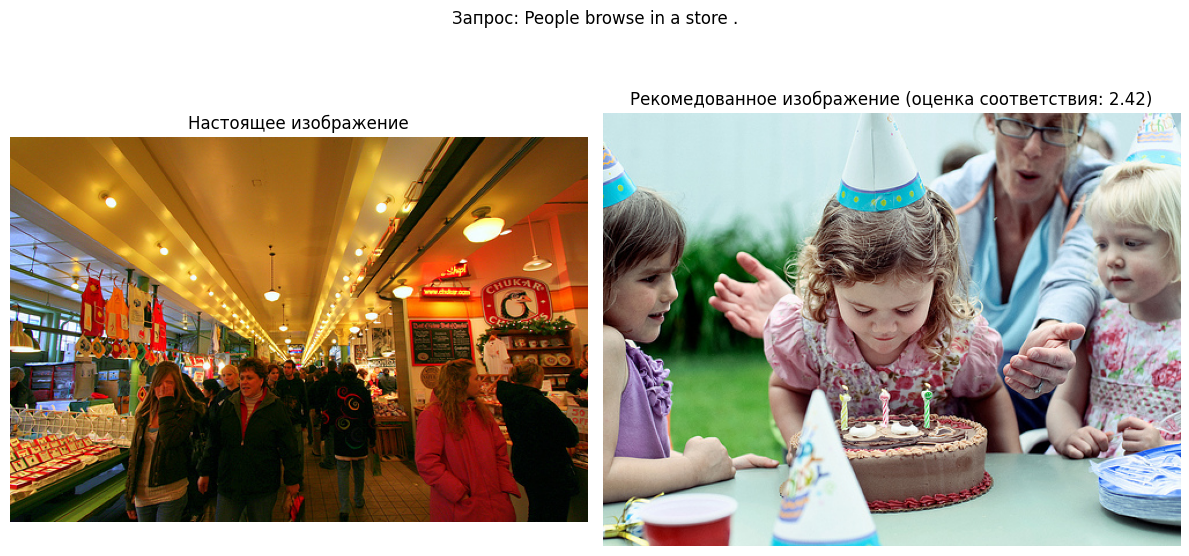

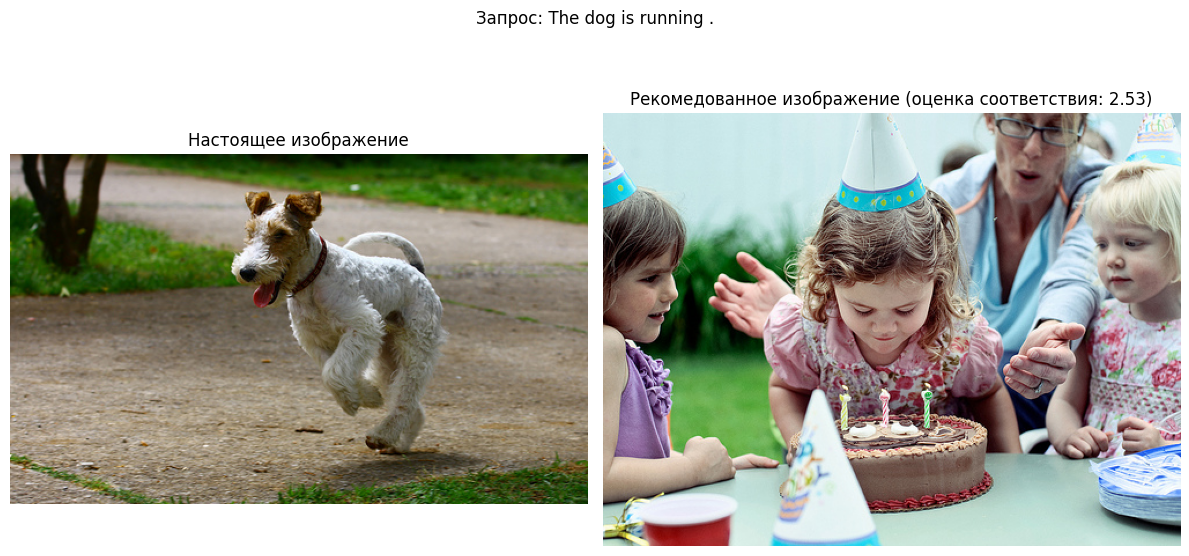

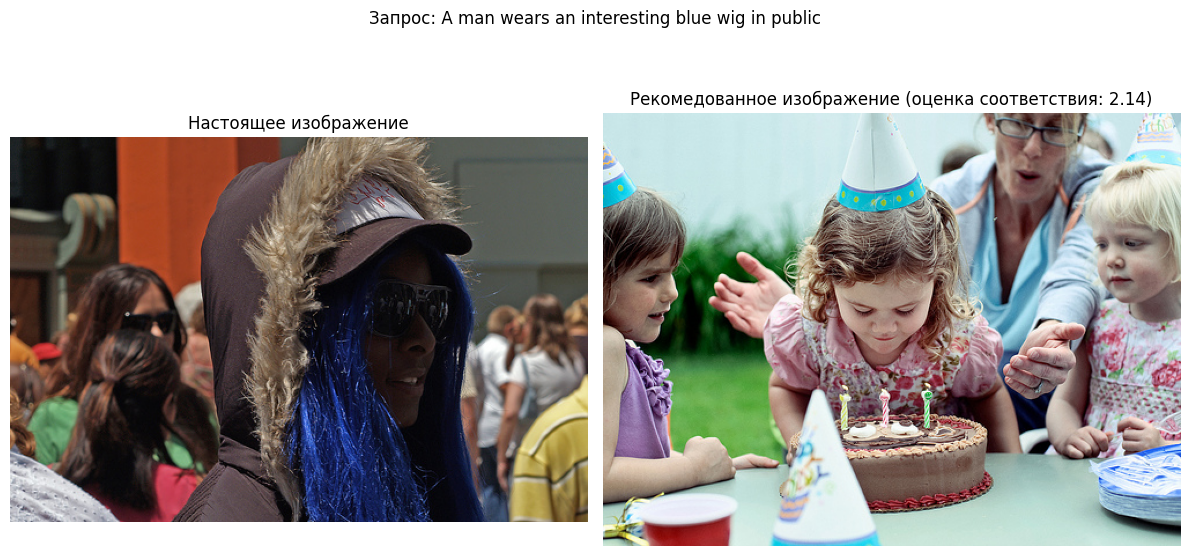

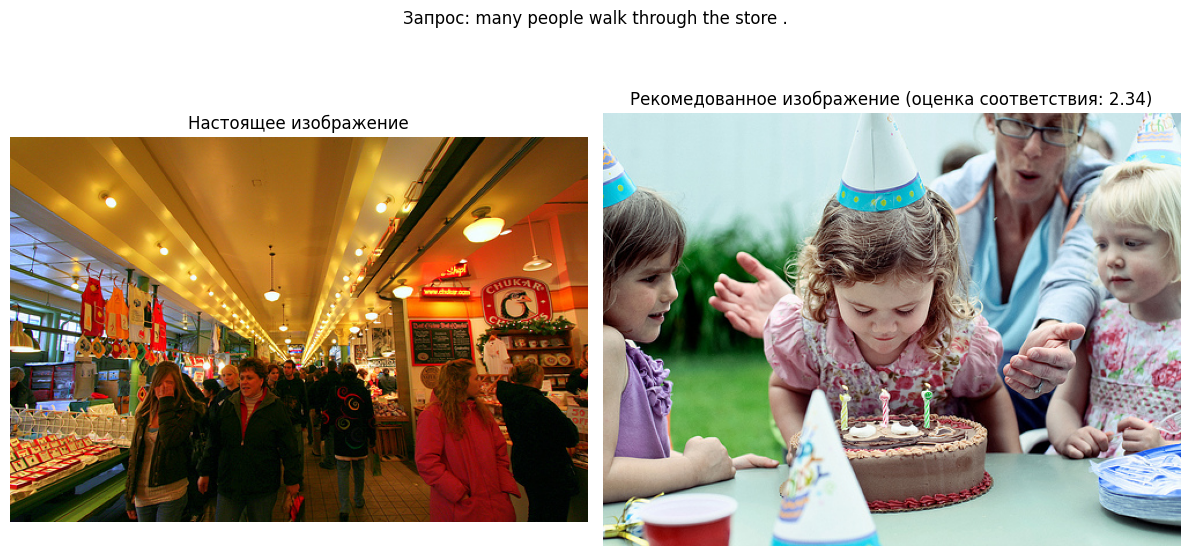

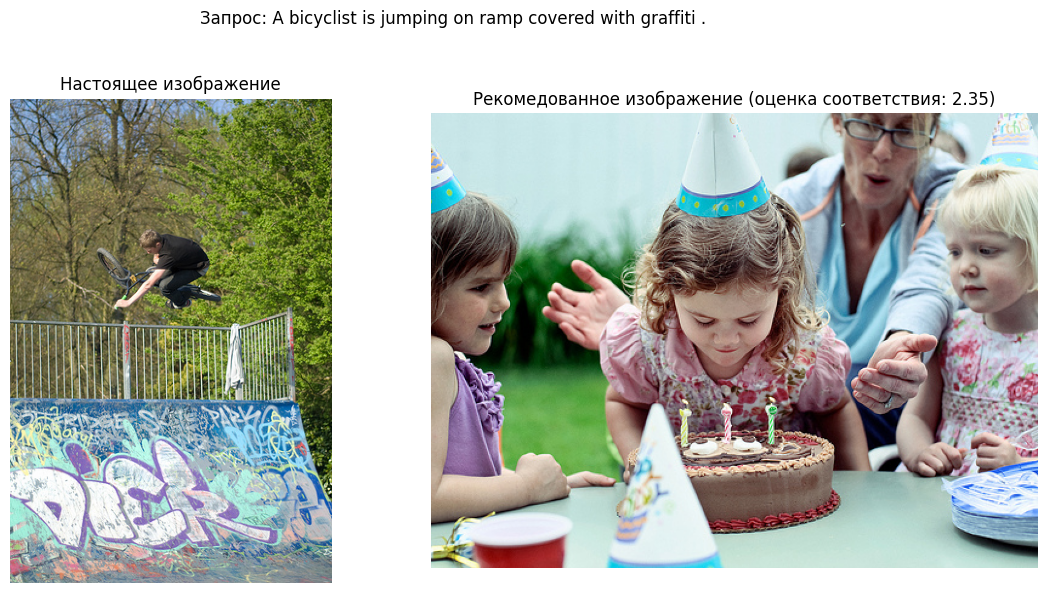

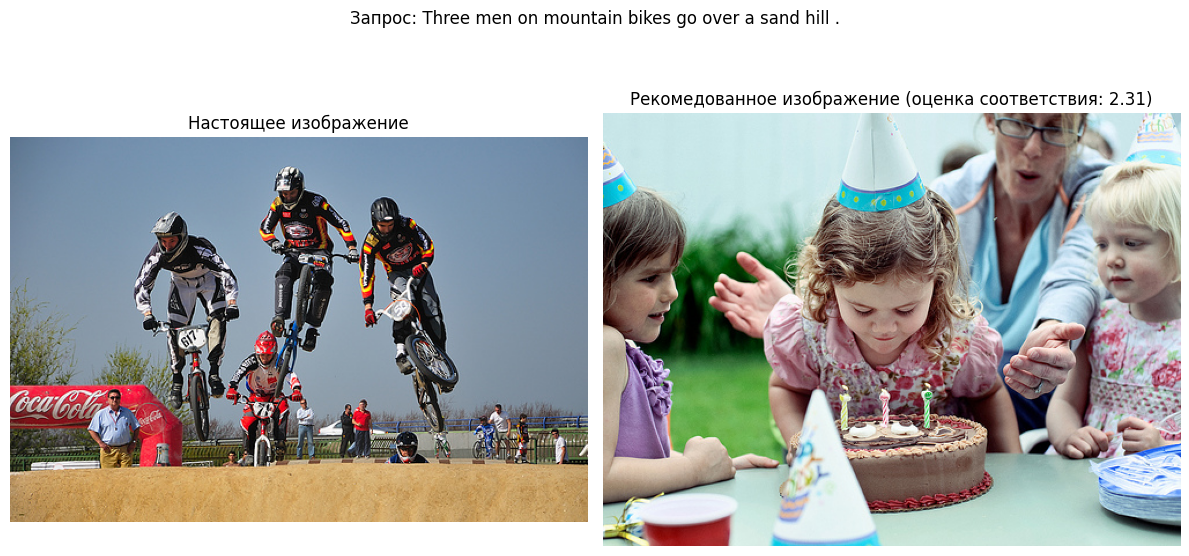

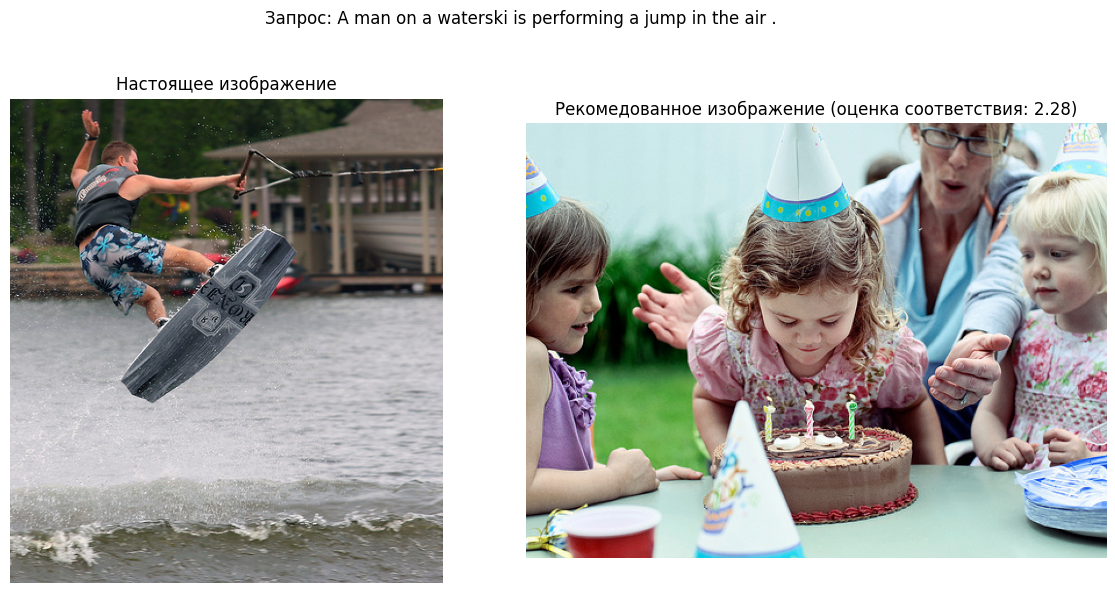

In [92]:
for p in predictions: 
    if p == None:
        continue

    query = p[0]
    true_image = plt.imread('/kaggle/input/dsplus-sp4/to_upload/test_images/' + p[1])
    predicted_image = plt.imread('/kaggle/input/dsplus-sp4/to_upload/test_images/' + p[2])
    score = p[3]
    
    # Create a figure with one row for the text and two columns for the images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the query text as the title of the figure
    fig.suptitle("Запрос: " + query, fontsize=12)
    
    # Display the true image
    ax[0].imshow(true_image)
    ax[0].set_title('Настоящее изображение')
    ax[0].axis('off')
    
    # Display the predicted image
    ax[1].imshow(predicted_image)
    ax[1].set_title(f'Рекомедованное изображение (оценка соответствия: {str(round(score, 2))})')
    ax[1].axis('off')
    
    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the suptitle
    plt.show()

Для демонстрации работы модели была написана фукнция поиска наиболее релевантного изображения из тестовой выборки по запросу. Для выполнения такого поиска все изображения из тестовой выборе были преобразованы в вектора признаков с помощью нейронной сети ResNet50, исходный текстовый запрос был преобразован в векторный формат с помощью модели Bert, затем производится предсказание коэффициента соответствия каждого из изображений текстовому запросу с использованием уже обученной модели и путем ранжирования результатов предсказания модели позвращается наиболее релевантное изображение, т.е. изображение с наибольшим значением коэффициента соответствия.

Как видно из результатов работы функции поиска выше, модель работает не совсем корректно, так как на любой текстовый запрос возвращается одна и та же картинка. Для дальнейшего изучения и отладки работы модели необходимо более глубокое погружение в процесс генерации векторных признаков из изображений и из текстовых описаний, а так же более глубокое понинмание диагностики регрессионных моделей, что остается за рамками данной работы.

## 8. Выводы

В данной работе была разработать демонстрационную версия сервиса поиска изображений по запросу. Для демонстрационной версии была обучена модель, которая генерирует векторное представление изображения, векторное представление текста, а на выходе выдает число коэффициент соответствия текста и картинки. 

**Исследовательский анализ исходных данных**

Данные с оценками исполнителей содержат 47830 пар имя картинки - идентификатор описания. Из распределения доли оценок исполнителей, подтвердивших соответсвие картинки и текста, можно сделать вывод, что подавляющее большинство изображений не соответствует описанию и соответсвует не совсем точно и лишь небольшая доля изображений (<3%) полностью соответствует описанию, по мнению исполнителей.

Данные с оценками экспертов содержат 5822 пар имя картинки - идентификатор описания, что намного меньше количества записей с оценками исполнителей. То есть как минимум для части изображений отсутствуют данные об оценках экспертов. Из распределения оценок экспертов можно сделать выводы, что оценки 1 и 2, говорящие о низком соответсвии изображения картинке встречаются наиболее часто, в то время как оценки 3 и особенно 4 встречаются редко. Так же можно заключить, что эксперт №1 присваивает высокии оценки соответсвия реже, чем эксперты №2 и №3.

Оценки исполнителей и оценки экспертов были объединены в единый коэффициент соответсвия изображения описанию при помощи простого суммирования доли исполнителей, подтвердивших соответсвие изображения тексту (диапозон от 0 до 1) и суммы оценок трех экспертов (диапозон от 3 до 12). Так как оценки экспертов присутствуют не для всех изображений, пропущенные оценки были заменены на нулевые значения. Суммы были нормализованы, чтобы привести финальный коэффициент к диапозону от 0 до 1 для простоты дальнейшей работы.

В обучающей выборке содержатся 5822 записей с информацией об 1000 уникальных изображений и 977 уникальных описаний изображений, то есть одному изображению может соответствовать несколько описаний, а так же к одному описанию может подходить несколько изображений. После объединения информации об изображениях и текстовых описаниях в обучающей выборке с финальным коэффициентом соответсвия, полученным на основе оценок исполнителей и экспертов, получился набор данных размером 2329 записей, содержащий 766 уникальных описаний для 891 уникальных изображений.

Тестовая выборка содержит 100 изображений, а так же 500 пар соответствий изображения и текстового описания.

**Результаты обучения модели**

С помощью предобученной нейронной сети ResNet50 из исходных изображений был извлечен вектор признаков размерностью (1232, 2048), который в дальнейшем был использован для обучения регрессионных моделей.

С помощью модели Bert текст описания изображений был приведен в векторный вид, размерность вектора признаков, полученных из текстовых описаний - (1232, 30х30х30).

Вектора признаков изображений и текстовых описаний были объединены в единый вектор признаков, итоговая размерность вектора признаков - (1232, 2138). Признаки были масштабированы с помощью StandardScaler.

Для предсказания коэффициента соответсвия изображения текстовому описанию была обучена модель линейной регрессии с использованием оценки соответсвия, полученной из оценок исполнителей и оценок экспертов, в качестве целевой переменной для регресии. В качестве гиперпараметров модели были использованы и подобраны оптимальные значения скорости обучения и количеста эпох. Модель хорошо обучилась на тренировочных данных, о чем свидетельствует низкий показатель метркики среднеквадратичной ошибки, которая использовалась в качестве функции потерь. Тем не менее, значение среднеквадратичной ошибки на валидационной выборке на несколько порядков выше, чем на обучающей выборке, что свидетельствует о переобучении модели.

Далее для предсказания коэффициента соответсвия изображения текстовому описанию была обучена полносвязная нейронная сеть с двумя скрытыми слоями и функциями активации sigmoid и relu. Были подобраны оптимальные значения скорости обучения и количеста эпох. Полносвязаная нейронная сеть показала меньшую точность по метрике среднеквадратичной ошибки на тренировочных данных, но существенно лучшую точность на валидационной выборке. Разница в метрике между тренировочной и валидацонной выборками не велика, что говорит о том, что модель хорошо обучилась и научилась хорошо обобщать выводы.

По итогам сравнения результатов работы модели линейной регресии и полносвязной нейронной сети, лучшую точность на валидационной выборке показала полносвязная нейронная сеть. В дальнейшем для тестирования работы модели и для реализации функции поиска изображения из тестовой выборке по запросу будем использрвать именно эту модель с наилучшими гиперпараметрами.

**Тестирование модели**

Для демонстрации работы модели была написана фукнция поиска наиболее релевантного изображения из тестовой выборки по запросу. Для выполнения такого поиска все изображения из тестовой выборе были преобразованы в вектора признаков с помощью нейронной сети ResNet50, исходный текстовый запрос был преобразован в векторный формат с помощью модели Bert, затем производится предсказание коэффициента соответствия каждого из изображений текстовому запросу с использованием уже обученной модели и путем ранжирования результатов предсказания модели позвращается наиболее релевантное изображение, т.е. изображение с наибольшим значением коэффициента соответствия.

Как видно из результатов работы функции поиска выше, модель работает не совсем корректно, так как на любой текстовый запрос возвращается одна и та же картинка. Для дальнейшего изучения и отладки работы модели необходимо более глубокое погружение в процесс генерации векторных признаков из изображений и из текстовых описаний, а так же более глубокое понинмание диагностики регрессионных моделей, что остается за рамками данной работы.


- [x] Jupyter Notebook открыт
-[x] Весь код выполняется без ошибок
-[x] Ячейки с кодом расположены в порядке исполнения
-[x] Исследовательский анализ данных выполнен
-[x] Проверены экспертные оценки и краудсорсинговые оценки
-[x] Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
-[x] Изображения векторизованы
-[x] Текстовые запросы векторизованы
-[x] Данные корректно разбиты на тренировочную и тестовую выборки
-[x] Предложена метрика качества работы модели
-[x] Предложена модель схожести изображений и текстового запроса
-[x] Модель обучена
-[x] По итогам обучения модели сделаны выводы
-[x] Проведено тестирование работы модели
-[x] По итогам тестирования визуально сравнили качество поиска